In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import matplotlib
import torch

import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from flipper_training.experiments.ppo.eval import log_from_eval_rollout, PPOExperimentConfig, prepare_env
from torchrl.envs import StepCounter, VecNorm, TransformedEnv, set_exploration_type

/Users/davidkorcak/.venv/lib/python3.12/site-packages/torchrl/__init__.py:43: UserWarning: failed to set start method to spawn, and current start method for mp is fork.
  warn(


In [2]:
cfg_dict = OmegaConf.load("../cross_eval_configs/file_ridge.yaml")
cfg_dict["heightmap_gen_opts"]["file_path"] = "../heightmap_files/ridge.pt"
cfg = PPOExperimentConfig(**cfg_dict)

In [3]:
env, device, rng = prepare_env(cfg, mode="eval")
env = TransformedEnv(env, StepCounter())

2025-05-22 23:18:37,547 [RobotModelConfig][INFO]: Loading robot model from cache: /Users/davidkorcak/Documents/ctu/bachelors/flipper_training/.robot_cache/marv_vx0.010_dp384_b512_whl0.02_trck0.05_eaecc2d5466de1eb8911703837d75c759b5c075158ced88ea318e932700dabb2 (robot_config.py:155)
Initializing start/goal position cache: 100%|██████████| 16/16 [00:00<00:00, 92.00it/s]
2025-05-22 23:18:40,655 [environment][INFO]: Engine compiled successfully, testing correctness with atol=0.1, rtol=1e-06 (env.py:147)
2025-05-22 23:18:40,696 [environment][INFO]: Compiled engine passed correctness test (env.py:154)
2025-05-22 23:18:41,432 [environment][INFO]: Compiled engine takes 0.734948 ms per step (env.py:160)


                      Environment Summary                       
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                                  Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                                     16 │
│        Observations │            LocalStateVector, Heightmap │
│              Reward │ PotentialGoalWithPenaltiesConfigurable │
│           Objective │              RandomNavigationObjective │
│   Physics frequency │                              142.86 Hz │
│   Engine iters/step │                                      4 │
│ Effective frequency │                               35.71 Hz │
└─────────────────────┴────────────────────────────────────────┘

2025-05-22 23:18:43,466 [torchrl][INFO] check_env_specs succeeded!


In [4]:
policies = [
    "final_coarse_gaussian_terrain_thesis_98_2025-05-12_12-07-12",
    "final_mixed_objective_training_666_2025-05-16_19-08-25",
    "mixed_training_smoothness_2025-05-20_06-47-01",
]

from copy import deepcopy

p_root = Path("../runs/ppo/")
p_sds = [torch.load(p_root / f"{policy}/weights/policy_final.pth", map_location=device) for policy in policies]
vecnorm_sds = [torch.load(p_root / f"{policy}/weights/vecnorm_final.pth", map_location=device) for policy in policies]


In [5]:
policy_config = cfg.policy_config(**cfg.policy_opts)
actor_value_wrapper, optim_groups, policy_transforms = policy_config.create(
    env=env,
    device=device,
)
vecnorm = VecNorm(in_keys=[o.name for o in env.observations if o.supports_vecnorm], **cfg.vecnorm_opts)
vecnorm = vecnorm.to(device)

2025-05-22 23:18:43,565 [MLPPolicyConfig][INFO]: Applied orthogonal initialization to the actor and value operators. (mlp_policy.py:89)


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

In [6]:
env._set_truncate_mode(False)

In [7]:
set_exploration_type("DETERMINISTIC")

In [ ]:
import torch
import torch.nn.functional as F
import torch.distributions as D


class IteratedWeightedPolicy:
    def __init__(self, weights, policy_callables):
        self.weights = weights
        self.policy_callables = policy_callables
        self.i = 0

    def __call__(self, tensordict):
        weight_i = self.weights[self.i]  # (batch_size, num_policy_options)
        # actions: (num_policy_options, batch_size, action_dim)
        actions = []
        for p in self.policy_callables:
            actions.append(p(tensordict).pop("action"))
        actions = torch.stack(actions, dim=-1) # shape (batch_size, action_dim, num_policy_options)
        # Compute the weighted sum of actions
        action = (actions * weight_i.unsqueeze(1)).sum(dim=-1)
        self.i += 1
        tensordict.set("action", action)
        return tensordict


class MultiPolicyMPPIPlanner:
    def __init__(
        self,
        actor_value_wrapper,
        vecnorm_obj: VecNorm,
        weights: list,
        vecnorm_weights: list,
        env,  # Not directly used in these specific methods
        device,
        rng,  # rng is expected to be a torch.Generator or compatible
        rollout_steps=20,
        num_samples=10,
        lambda_=1.0,
        noise_sigma=0.1,
        temperature=1.0,
    ):  # MPPI hyperparameters
        self.env = env
        self.policies_callables = []
        self.num_policy_options = len(weights)
        for i in range(self.num_policy_options):
            aw = deepcopy(actor_value_wrapper)
            aw.load_state_dict(weights[i])
            policy = aw.get_policy_operator()
            policy = policy.to(device)
            policy.eval()
            vecnorm = deepcopy(vecnorm_obj)
            vecnorm.load_state_dict(vecnorm_weights[i])
            vecnorm = vecnorm.to(device)
            vecnorm.eval()
            self.policies_callables.append(lambda td: policy(vecnorm(td)))
        self.device = device
        self.rng = rng  # Expected to be a torch.Generator for torch.randn
        self.rollout_steps = rollout_steps
        self.num_samples = num_samples
        # MPPI specific parameters
        self.lambda_ = lambda_  # Cost scaling factor in importance weights
        self.noise_sigma = noise_sigma  # Standard deviation of Gaussian noise for logits
        self.temperature = temperature  # Temperature for softmax conversion of logits to policy weights
        self.mean_logits = torch.zeros(self.rollout_steps, self.env.n_robots, self.num_policy_options, device=self.device)
        self.last_logit_perturbations = None

    def __call__(self, tensordict):
        weights = self._get_rollout_weights()
        costs = torch.empty(self.num_samples, self.env.n_robots, device=self.device)
        step = tensordict.pop("_step", None)
        for s in range(self.num_samples):
            weight = weights[s]  # (rollout_steps, batch_size, num_policy_options)
            weighted_policy = IteratedWeightedPolicy(weight, self.policies_callables)
            with set_exploration_type("DETERMINISTIC"), torch.inference_mode():
                rollout = self.env.rollout(
                    auto_reset=False,
                    policy=weighted_policy,
                    tensordict=tensordict.clone(),
                    max_steps=self.rollout_steps,
                    break_when_any_done=False,  # never break early
                    break_when_all_done=True,
                )
                rew = rollout["next", "reward"].sum(dim=[0, 1])  # (batch_size,)
                costs[s] = -rew
        self.update_mean_logits(costs)  # shape (num_samples, batch_size)
        action = self._get_optimal_action(tensordict)
        tensordict.set("action", action)
        if step is not None:
            tensordict.set("_step", step)
        return tensordict
    
    def _get_optimal_action(self, tensordict):
        """
        Returns the optimal action for the first step of the current
        optimized mean trajectory for each batch element.

        Args:
            tensordict: The current observation/state. Not directly used for sampling
                        logic here but is standard for planners. It's cloned.
                        You'll use this when you evaluate the samples in your sim.

        Returns:
            torch.Tensor: Optimal action, shape (batch_size, action_dim).
        """
        # Get the optimal weights for the first step
        optimal_weights = self.get_optimal_action_weights()  # (batch_size, num_policy_options)
        # Get the actions from each policy
        actions = []
        for p in self.policies_callables:
            actions.append(p(tensordict).pop("action"))  # (batch_size, action_dim)
        actions = torch.stack(actions, dim=-1)  # (num_policy_options, batch_size, action_dim)
        # Compute the weighted sum of actions
        action = (actions * optimal_weights.unsqueeze(1)).sum(dim=-1)  # (batch_size, action_dim)
        return action
    
    def _get_rollout_weights(self):
        """
        Performs the sampling step of MPPI.
        Generates `num_samples` sequences of policy-blending weights.

        Args:
            tensordict: The current observation/state. Not directly used for sampling
                        logic here but is standard for planners. It's cloned.
                        You'll use this when you evaluate the samples in your sim.

        Returns:
            torch.Tensor: Sampled policy weight sequences, shape
                          (num_samples, rollout_steps, num_policy_options).
                          These are the weights you'll use to linearly combine your policies.
        """
        # 1. Shift mean logits for receding horizon control
        # The mean logits from the previous timestep are shifted, and the last step is re-initialized.
        shifted_logits = self.mean_logits[1:].clone()
        # Initialize the new last step logits to zeros (or another strategy)
        new_last_step_logits = torch.zeros(1, self.env.n_robots, self.num_policy_options, device=self.device)
        self.mean_logits = torch.cat((shifted_logits, new_last_step_logits), dim=0)
        logit_perturbations = (
            torch.randn(self.num_samples, self.rollout_steps, self.env.n_robots, self.num_policy_options, device=self.device) * self.noise_sigma
        )
        # Store perturbations for the update_mean_logits step
        self.last_logit_perturbations = logit_perturbations
        # 3. Create sampled logits
        # Broadcast mean_logits: (1, rollout_steps, 3) + (num_samples, rollout_steps, 3)
        sampled_logits = self.mean_logits.unsqueeze(0) + self.last_logit_perturbations
        # 4. Convert sampled logits to policy weights using softmax
        # This ensures weights for the 3 policies sum to 1 and are non-negative at each step.
        # sampled_policy_weights shape: (num_samples, rollout_steps, num_policy_options)
        sampled_policy_weights = F.softmax(sampled_logits / self.temperature, dim=-1)
        # These sampled_policy_weights are what you'll use in your environment
        # to simulate the `num_samples` different trajectories.
        return sampled_policy_weights

    def update_mean_logits(self, costs: torch.Tensor):
        """
        Updates mean logits using costs for each batch element independently.

        Args:
            costs (torch.Tensor): Costs for each sample and batch element,
                                shape (num_samples, batch_size).
        """
        if self.last_logit_perturbations is None:
            raise RuntimeError("`__call__` must be invoked first.")
        if costs.shape != (self.num_samples, self.env.n_robots):
            raise ValueError(f"Expected costs shape ({self.num_samples}, {self.env.n_robots}), got {costs.shape}")
        costs = costs.to(self.device)

        # Compute exponent terms per sample and batch element
        exponent_terms = -costs / self.lambda_  # (num_samples, batch_size)
        max_exponents = torch.max(exponent_terms, dim=0)[0]  # (batch_size,)
        stable_exponent_terms = exponent_terms - max_exponents.unsqueeze(0)  # (num_samples, batch_size)
        importance_weights = torch.exp(stable_exponent_terms)  # (num_samples, batch_size)
        # Normalize weights per batch element
        sum_of_weights = torch.sum(importance_weights, dim=0)  # (batch_size,)
        epsilon = 1e-9
        normalized_weights = importance_weights / (sum_of_weights.unsqueeze(0) + epsilon)  # (num_samples, batch_size)
        # Compute update delta
        weighted_perturbations = (
            normalized_weights.unsqueeze(1).unsqueeze(-1) * self.last_logit_perturbations
        )  # (num_samples, 1, batch_size, 1) * (num_samples, rollout_steps, batch_size, num_policy_options)
        update_delta = torch.sum(weighted_perturbations, dim=0)  # (rollout_steps, batch_size, num_policy_options)
        self.mean_logits += update_delta
        self.last_logit_perturbations = None

    def get_optimal_action_weights(self):
        """
        Returns the policy blending weights for the *first step* of the current
        optimized mean trajectory for each batch element.

        Returns:
            torch.Tensor: Optimal policy blending weights, shape
                          (batch_size, num_policy_options).
        """
        # Get the mean logits for the first step of the planned horizon
        first_step_mean_logits = self.mean_logits[0, :, :]  # (batch_size, num_policy_options)
        # Convert these logits to policy weights using softmax with temperature
        optimal_weights = F.softmax(first_step_mean_logits / self.temperature, dim=-1)
        return optimal_weights


class PolicyBlenderCEM:
    def __init__(
        self,
        policy_obj,
        vecnorm_obj: VecNorm,
        weights: list,
        vecnorm_weights: list,
        env,  # Not directly used in these specific methods
        device,
        rng,  # rng is expected to be a torch.Generator or compatible
        rollout_steps=20,
        num_samples=10,
        elite_fraction=0.2,
        num_iterations=10,
    ):  # MPPI hyperparameters
        self.env = env
        self.policies_callables = []
        self.num_policy_options = len(weights)
        for i in range(self.num_policy_options):
            policy = deepcopy(policy_obj)
            policy.load_state_dict(weights[i])
            policy = policy.to(device)
            policy.eval()
            vecnorm = deepcopy(vecnorm_obj)
            vecnorm.load_state_dict(vecnorm_weights[i])
            vecnorm = vecnorm.to(device)
            vecnorm.eval()
            self.policies_callables.append(lambda td: policy(vecnorm(td)))
        self.device = device
        self.rng = rng  # Expected to be a torch.Generator for torch.randn
        self.num_samples = num_samples
        self.num_elites = int(elite_fraction * num_samples)
        self.num_iterations = num_iterations
        self.num_policies = len(policies)
        self.rollout_steps = rollout_steps
        self.alpha = torch.ones(self.env.n_robots, self.num_policies, device=device)

    def __call__(self, tensordict):
        step = tensordict.pop("_step", None)
        for _ in range(self.num_iterations):
            # Sample weights
            dist = D.Dirichlet(self.alpha)
            weights = dist.sample((self.num_samples,))  # (num_samples, batch_size, num_policies)
            # Evaluate samples over rollout_steps
            costs = torch.empty(self.num_samples, self.env.n_robots, device=self.device)
            for k in range(self.num_samples):
                w_k = weights[k]  # (batch_size, num_policies)

                # Define policy that uses constant weights over the horizon
                def weighted_policy(td):
                    actions = torch.stack([p(td) for p in self.policies_callables], dim=-1)  # (num_policies, batch_size, action_dim)
                    action = (actions * w_k).sum(dim=-1)  # (batch_size, action_dim)
                    return action

                with set_exploration_type("DETERMINISTIC"), torch.inference_mode():
                    rollout = self.env.rollout(
                        auto_reset=False,
                        policy=weighted_policy,
                        tensordict=tensordict.clone(),
                        max_steps=self.rollout_steps,
                        break_when_any_done=False,  # never break early
                        break_when_all_done=True,
                    )
                    cost = -rollout["next", "reward"].sum(dim=[0,1])  # (batch_size,)
                costs[k] = cost
            # Select elites
            _, elite_indices = torch.topk(-costs, self.num_elites, dim=0)
            elite_weights = torch.gather(
                weights, 0, elite_indices.unsqueeze(-1).expand(-1, -1, self.num_policies)
            )  # (num_elites, batch_size, num_policies)

            # Update Dirichlet parameters
            mean_elite_weights = elite_weights.mean(dim=0)  # (batch_size, num_policies)
            self.alpha = mean_elite_weights * 10.0 + 1e-3

        # Return optimal weights for the first step
        optimal_weights = self.alpha / self.alpha.sum(dim=-1, keepdim=True)  # (batch_size, num_policies)
        # Get the actions from each policy
        actions = torch.stack([p(tensordict).pop("action") for p in self.policies_callables], dim=-1)
        # Compute the weighted sum of actions
        action = (actions * optimal_weights.unsqueeze(1)).sum(dim=-1)
        tensordict.set("action", action)
        if step is not None:
            tensordict.set("_step", step)
        return tensordict

In [9]:
steps = 10
num_samples = 10
lambda_ = 1.0
noise_sigma = 0.1
temperature = 1.0
planner = MultiPolicyMPPIPlanner(
    actor_value_wrapper=actor_value_wrapper,
    vecnorm_obj=vecnorm,
    weights=p_sds,
    vecnorm_weights=vecnorm_sds,
    env=env,
    device=device,
    rng=rng,
    rollout_steps=steps,
    num_samples=num_samples,
    lambda_=lambda_,
    noise_sigma=noise_sigma,
    temperature=temperature,
)
env.reset()
rollout = env.rollout(500, planner, break_when_all_done=True, break_when_any_done=False)

/Users/davidkorcak/.venv/lib/python3.12/site-packages/torchrl/envs/transforms/transforms.py:6500: UserWarning: VecNorm wasn't initialized and the tensordict is not shared. In single process settings, this is ok, but if you need to share the statistics between workers this should require some attention. Make sure that the content of VecNorm is transmitted to the workers after calling load_state_dict and not before, as other workers may not have access to the loaded TensorDict.
  warnings.warn(


KeyboardInterrupt: 

In [13]:
steps = 2
num_samples = 10
elite_fraction = 0.2
num_iterations = 2
planner = PolicyBlenderCEM(
    policy_obj=actor_value_wrapper,
    vecnorm_obj=vecnorm,
    weights=p_sds,
    vecnorm_weights=vecnorm_sds,
    env=env,
    device=device,
    rng=rng,
    rollout_steps=steps,
    num_samples=num_samples,
    elite_fraction=elite_fraction,
    num_iterations=num_iterations,
)
rollout = env.rollout(500, planner, break_when_all_done=True, break_when_any_done=False)

KeyboardInterrupt: 

In [11]:
log = log_from_eval_rollout(rollout)
log

{'eval/mean_step_reward': nan,
 'eval/max_step_reward': nan,
 'eval/min_step_reward': nan,
 'eval/mean_step_count': nan,
 'eval/max_step_count': nan,
 'eval/min_step_count': nan,
 'eval/pct_succeeded': 0.0,
 'eval/pct_failed': 0.0,
 'eval/pct_truncated': 1.0}

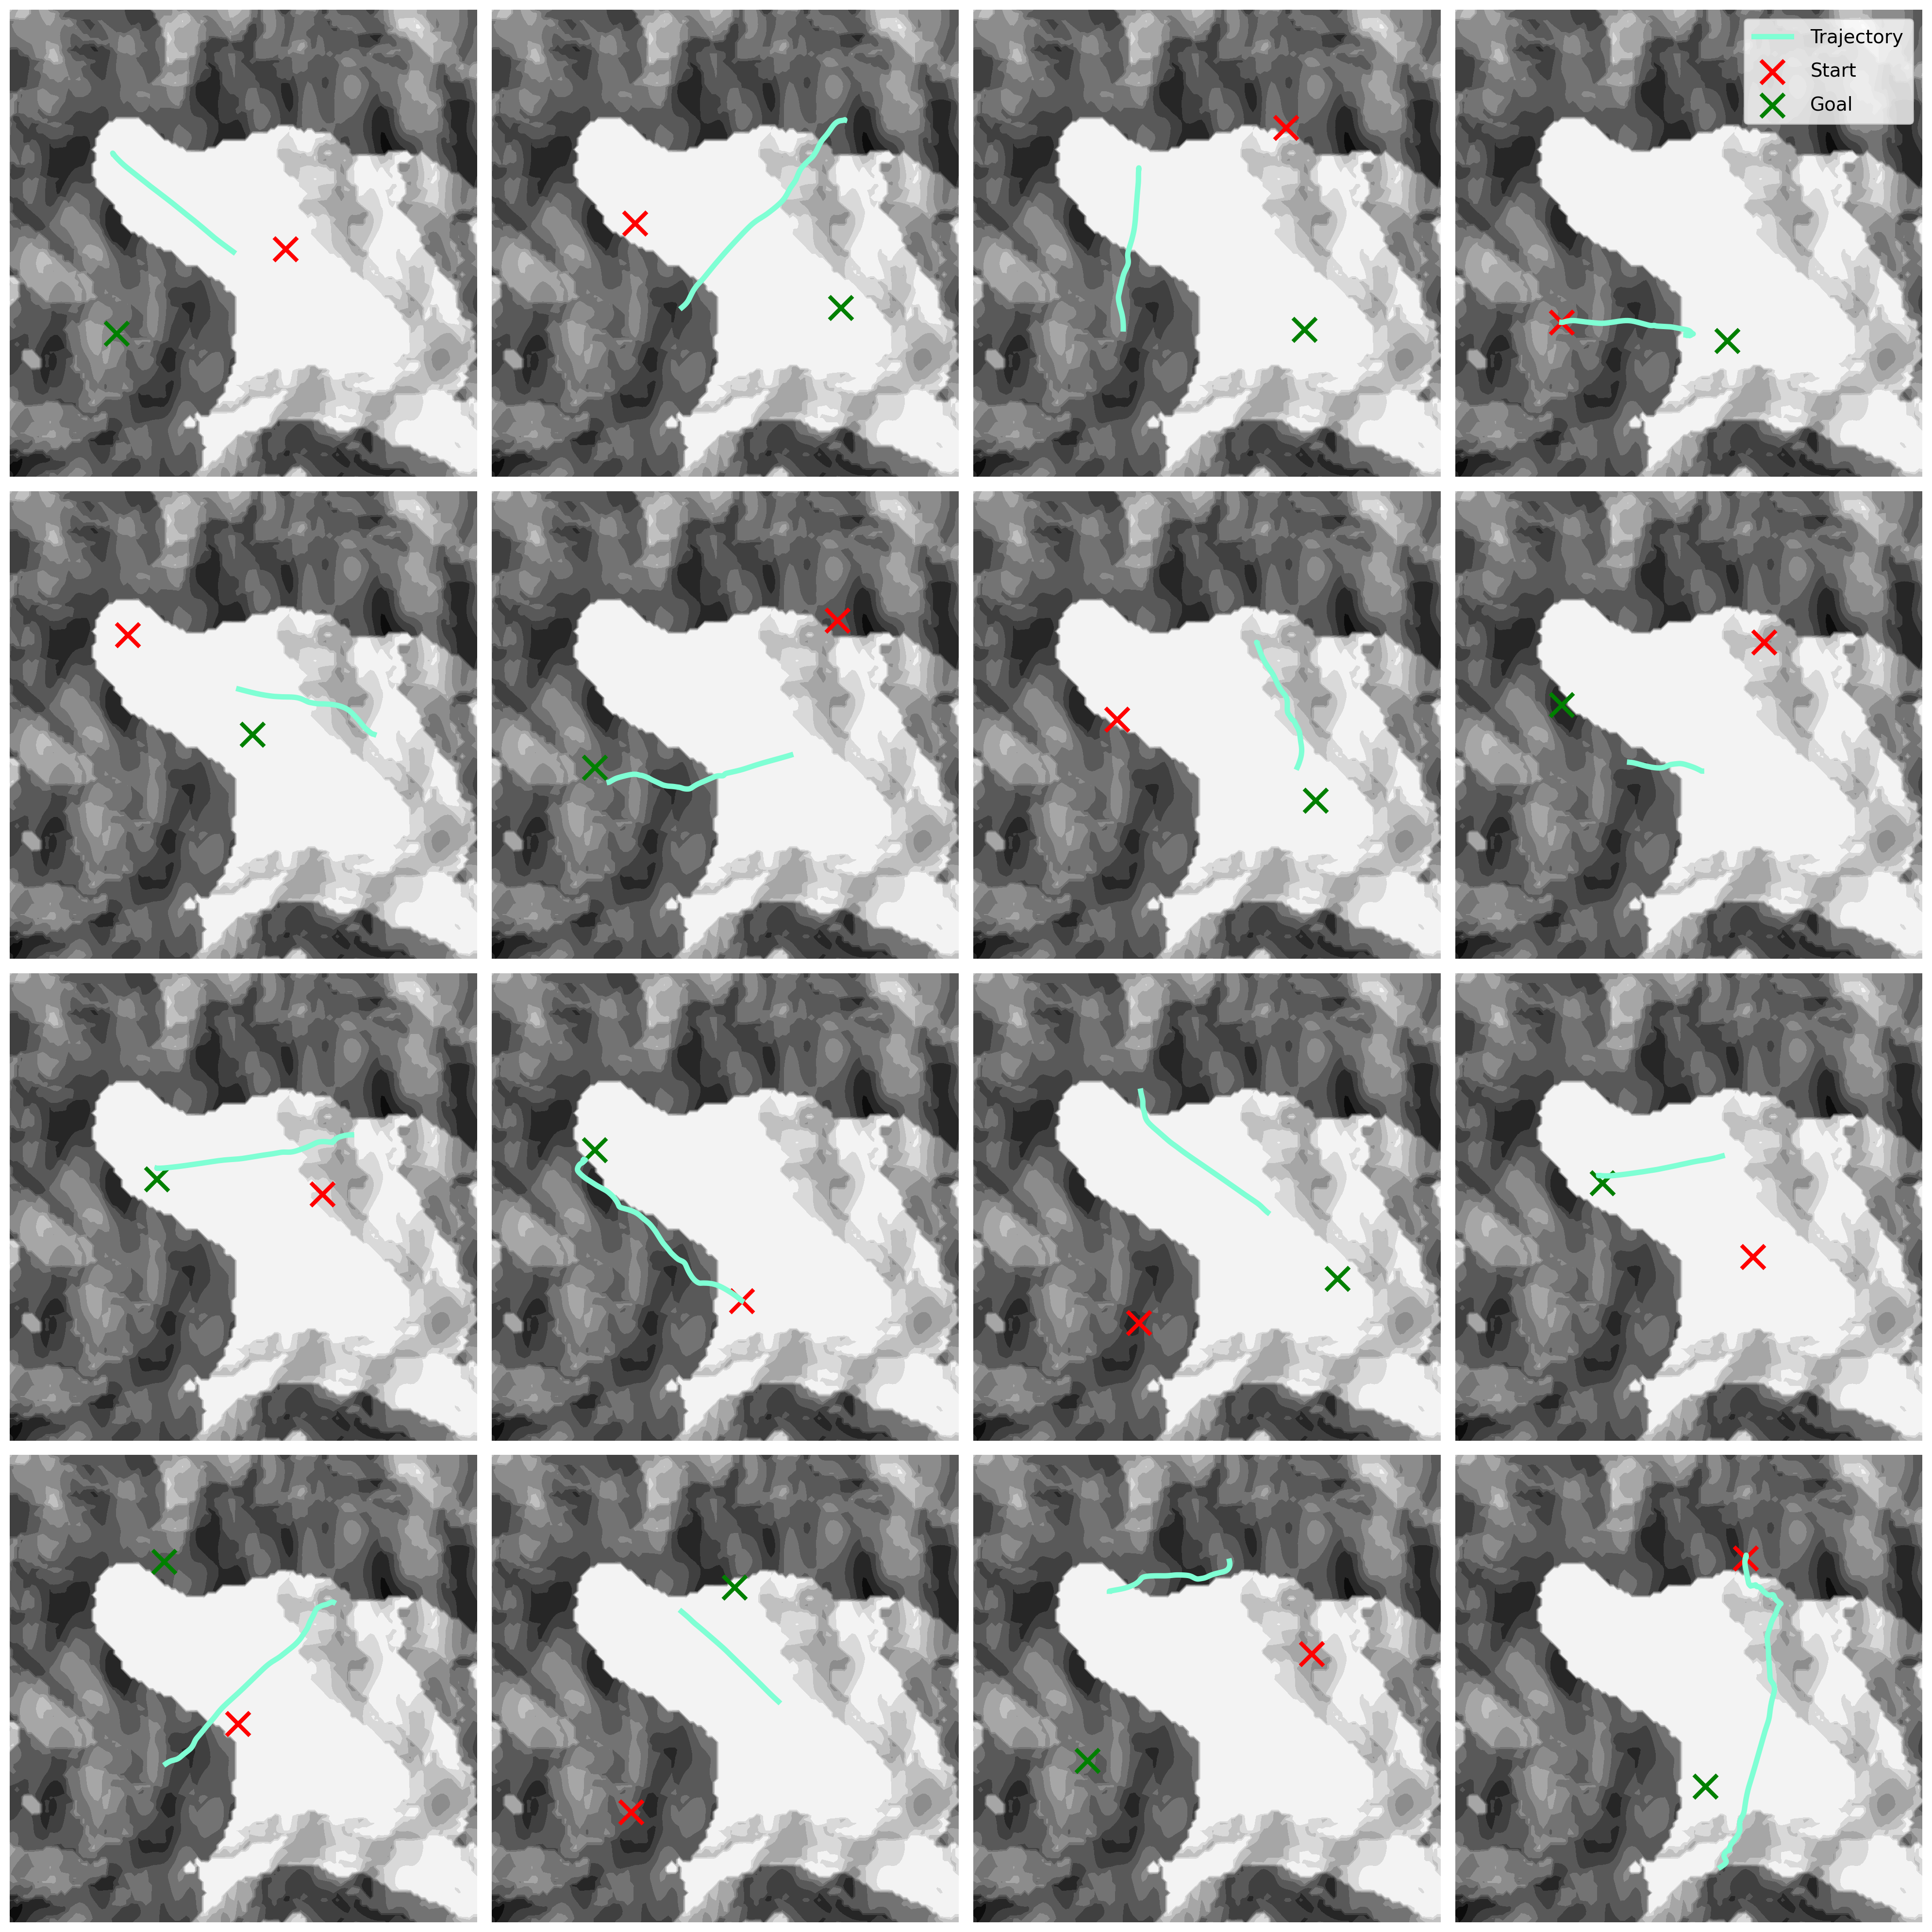

In [ ]:
terrain_cfg = env.terrain_cfg
trajectories = rollout["next", "curr_state"]["x"].cpu()
z_normalized = terrain_cfg.z_grid / terrain_cfg.z_grid.max()
z_normalized = z_normalized.cpu()
x_grid = terrain_cfg.x_grid.cpu()
y_grid = terrain_cfg.y_grid.cpu()
col = 4
row = 4
single_size = 5
indices_to_show = range(0, row * col)
fig, ax = plt.subplots(row, col, figsize=(col * single_size, row * single_size), dpi=200)
if ax.ndim == 1:
    ax = ax.reshape(1, -1)
j = 0
for i in indices_to_show:
    row_idx = j // col
    col_idx = j % col
    j += 1
    start_pos = env.start[i].x.cpu()
    goal_pos = env.goal[i].x.cpu()
    ax[row_idx, col_idx].grid(False)
    ax[row_idx, col_idx].axis("off")
    ax[row_idx, col_idx].contourf(
        x_grid[i],
        y_grid[i],
        z_normalized[i],
        cmap="gray",
        levels=10,
    )
    done_i = rollout["next", "done"][i].cpu()
    not_done = ~done_i
    traj_i = trajectories[i, not_done.squeeze(), :2]
    ax[row_idx, col_idx].plot(
        traj_i[:, 0],
        traj_i[:, 1],
        color="aquamarine",
        linewidth=4,
        label="Trajectory",
    )
    ax[row_idx, col_idx].scatter(
        start_pos[None, 0],
        start_pos[None, 1],
        color="red",
        marker="x",
        s=300,
        label="Start",
        lw=3,
    )
    ax[row_idx, col_idx].scatter(
        goal_pos[None, 0],
        goal_pos[None, 1],
        color="green",
        marker="x",
        s=300,
        label="Goal",
        lw=3,
    )
    fig.tight_layout()

ax[0, -1].legend(
    fontsize=14,
    loc="upper right",
    borderpad=0.5,  # padding around the legend
    labelspacing=0.8,  # vertical space between entries
    handletextpad=1.0,  # space between handle and text
)